Try gradient-descent training of MPS model on a GHZ state (including rotated bases)

In [1]:
import numpy as np
import torch
from models import MPS, ComplexTensor
import matplotlib.pyplot as plt
from tools import generate_binary_space

In [2]:
#helper function to build unitaries from angles
from qtools import pauli_exp

In [19]:
#system size
L=4
#dimensionality of local hilbert space (2 =qubit)
local_dim =2
#bond dimension of the MPS
bond_dim = 2

Creates uniform, closed-boundary-conditions MPS pure state

In [20]:
psi =MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [21]:
psi.tensors

[ComplexTensor shape torch.Size([2, 1, 2]),
 ComplexTensor shape torch.Size([2, 2, 2]),
 ComplexTensor shape torch.Size([2, 2, 2]),
 ComplexTensor shape torch.Size([2, 2, 1])]

Load datasets from numpy pickles

In [6]:
samples_fname = "samples_ghz_plus_all_discrete_bases_angles_L=4.npy"
settings_fname = "settings_ghz_plus_all_discrete_bases_angles_L=4.npy"
samples = np.load(samples_fname)
settings = np.load(settings_fname)

Tensors which specify local measurement settings

In [7]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

Tensor holding the corresponding unitaries

In [44]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

Convert samples to binary 0, 1

In [45]:
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)

In [46]:
from torch.utils.data import TensorDataset, DataLoader

In [47]:
class MeasurementDataset(TensorDataset):
    def __init__(self, samples, settings):
        super().__init__()
        if samples.shape[0] != settings.shape[0]:
            raise ValueError
        self.samples = TensorDataset(samples)
        self.settings = TensorDataset(settings)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        samples = self.samples[i][0]
        rot = self.settings[i][0]
        return dict(samples=samples, rotation=dict(real=rot.real,imag=rot.imag))

In [48]:
batch_size = 128
epochs = 5

In [49]:
ds = MeasurementDataset(samples_tr, U)

In [50]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [51]:
lr = .001
optim = torch.optim.SGD(lr=lr,params=psi.parameters())

In [52]:
losses = []
p10 = []
p01 = []
p0 = []
p1 = []

For my curiosity -- record probability assigned to a few basis states during training

In [53]:
x10 = torch.tensor([1,0,1,0], dtype=torch.long)
x01 = 1-x10
x0= torch.zeros(1, L,dtype=torch.long)
x1 = torch.ones(1,L,dtype=torch.long)

Train the MPS by minimizing negative-log-likelihood of the observed data.

In [54]:
for n in range(epochs):
    for i,meas in enumerate(dl):
        samples = meas['samples']
        rot = meas['rotation']
        rotation = ComplexTensor(rot['real'], rot['imag'])
        psi.zero_grad()
        loss = psi.nll_loss(samples,rotation=rotation)
        loss.backward()
        optim.step()
        if i%100==0:
            losses.append(loss)
            p10.append(psi.prob_normalized(x10))
    print("finished epoch %d" %n)

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


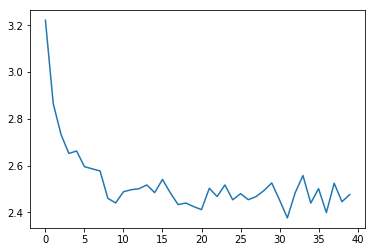

In [55]:
%matplotlib inline
plt.plot(losses)

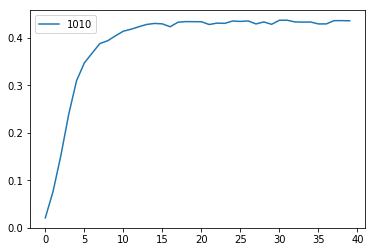

In [56]:
plt.plot(p10, label="1010")
plt.legend()

Look at the probability the trained state assigns to each z-basis state

In [25]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [71]:
with torch.no_grad():
    n = psi.norm().sqrt().item()
    for i in range(len(basis)):
        a = psi.amplitude(basis[i])
        print("{0} has amplitude {1:.4f} + i {2:.4f}, prob {3:.4f}".format(basis[i], 
                                                                            a.real.item()/n, a.imag.item()/n,
                                                                          psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has amplitude -0.0864 + i -0.0441, prob 0.0094
tensor([1, 1, 1, 0]) has amplitude -0.0924 + i -0.0306, prob 0.0095
tensor([1, 1, 0, 1]) has amplitude 0.0822 + i 0.0645, prob 0.0109
tensor([1, 1, 0, 0]) has amplitude 0.0797 + i 0.0393, prob 0.0079
tensor([1, 0, 1, 1]) has amplitude 0.0971 + i 0.0304, prob 0.0104
tensor([1, 0, 1, 0]) has amplitude -0.0945 + i -0.6539, prob 0.4365
tensor([1, 0, 0, 1]) has amplitude -0.0838 + i -0.0420, prob 0.0088
tensor([1, 0, 0, 0]) has amplitude -0.1002 + i -0.0293, prob 0.0109
tensor([0, 1, 1, 1]) has amplitude -0.0751 + i -0.0648, prob 0.0098
tensor([0, 1, 1, 0]) has amplitude -0.0746 + i -0.0439, prob 0.0075
tensor([0, 1, 0, 1]) has amplitude -0.6076 + i 0.2512, prob 0.4322
tensor([0, 1, 0, 0]) has amplitude 0.0791 + i 0.0622, prob 0.0101
tensor([0, 0, 1, 1]) has amplitude 0.0752 + i 0.0386, prob 0.0071
tensor([0, 0, 1, 0]) has amplitude 0.0948 + i 0.0368, prob 0.0103
tensor([0, 0, 0, 1]) has amplitude -0.0706 + i -0.0761, prob 

In [72]:
theta = torch.tensor([[np.pi/2]*L])
phi = torch.zeros_like(theta)
U = pauli_exp(theta, phi)

with torch.no_grad():
    n = psi.norm().sqrt().item()
    for i in range(len(basis)):
        a = psi.amplitude(basis[i],rotation=U)
        print("{0} has amplitude {1:.4f} + i {2:.4f}".format(basis[i], a.real.item()/n, a.imag.item()/n))

tensor([1, 1, 1, 1]) has amplitude -0.2207 + i -0.1231
tensor([1, 1, 1, 0]) has amplitude -0.1473 + i 0.2480
tensor([1, 1, 0, 1]) has amplitude 0.1184 + i -0.2144
tensor([1, 1, 0, 0]) has amplitude 0.2165 + i 0.1185
tensor([1, 0, 1, 1]) has amplitude -0.1206 + i 0.2087
tensor([1, 0, 1, 0]) has amplitude -0.2124 + i -0.1261
tensor([1, 0, 0, 1]) has amplitude 0.2294 + i 0.1363
tensor([1, 0, 0, 0]) has amplitude 0.1142 + i -0.2063
tensor([0, 1, 1, 1]) has amplitude 0.1348 + i -0.2447
tensor([0, 1, 1, 0]) has amplitude -0.1163 + i -0.0611
tensor([0, 1, 0, 1]) has amplitude -0.2182 + i -0.1156
tensor([0, 1, 0, 0]) has amplitude -0.1342 + i 0.2435
tensor([0, 0, 1, 1]) has amplitude 0.2100 + i 0.1204
tensor([0, 0, 1, 0]) has amplitude 0.1353 + i -0.2392
tensor([0, 0, 0, 1]) has amplitude -0.1212 + i 0.2054
tensor([0, 0, 0, 0]) has amplitude -0.2133 + i -0.1266
